# **Mujoco Playground**

https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/dm_control_suite.ipynb#scrollTo=C_1CY9xDoUKw

In [1]:
# 产看 Jax 是否可以使用 Nvidia 显卡
import jax
from jax import numpy as jp

# 检查JAX设备配置和GPU可用性
print("JAX devices:", jax.devices())
print("JAX default backend:", jax.default_backend())
gpu_devices = [d for d in jax.devices() if d.platform == 'gpu']
print("CUDA devices:", gpu_devices if gpu_devices else "No CUDA devices found")

# 检查当前计算在哪个设备上进行
test_array = jp.array([1.0, 2.0, 3.0])
print(f"Test array device: {test_array.device}")

# 检查是否可以使用GPU
try:
    import os
    print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")
    print(f"JAX_PLATFORM_NAME: {os.environ.get('JAX_PLATFORM_NAME', 'Not set')}")
except:
    pass

JAX devices: [CudaDevice(id=0)]
JAX default backend: gpu
CUDA devices: [CudaDevice(id=0)]
Test array device: cuda:0
CUDA_VISIBLE_DEVICES: Not set
JAX_PLATFORM_NAME: Not set
Test array device: cuda:0
CUDA_VISIBLE_DEVICES: Not set
JAX_PLATFORM_NAME: Not set


In [2]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

# **Intro**
使用倒立摆环境

In [3]:
from mujoco_playground import registry
env = registry.load('CartpoleBalance')
env

In [4]:
env_cfg = registry.get_default_config('CartpoleBalance')
env_cfg

action_repeat: 1
ctrl_dt: 0.01
episode_length: 1000
sim_dt: 0.01
vision: false
vision_config:
  enabled_geom_groups:
  - 0
  - 1
  - 2
  gpu_id: 0
  history: 3
  render_batch_size: 512
  render_height: 64
  render_width: 64
  use_rasterizer: false

# **Rollout**

In [5]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [6]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|██████████| 1001/1001 [00:00<00:00, 1232.81it/s]



In [7]:
state.obs.device

CudaDevice(id=0)

# **RL**

In [8]:
from mujoco_playground.config import dm_control_suite_params
ppo_params = dm_control_suite_params.brax_ppo_config('CartpoleBalance')
ppo_params

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30

# **PPO**

In [9]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

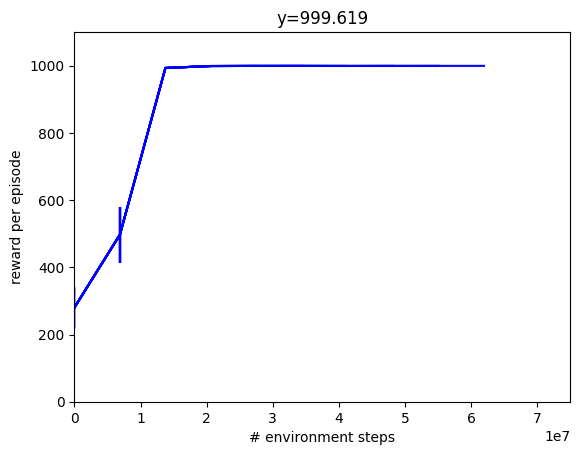

time to jit: 0:00:12.601745
time to train: 0:01:12.853001


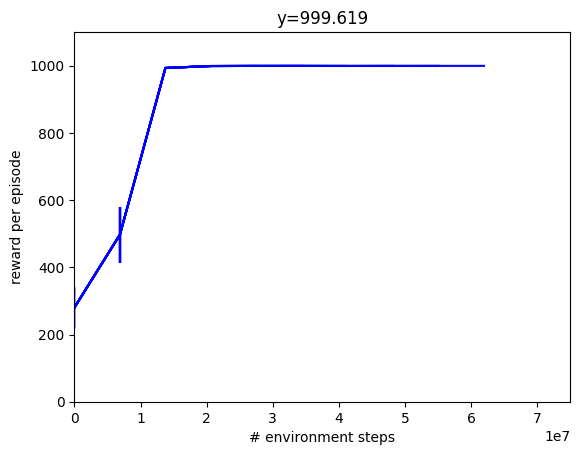

In [10]:
from mujoco_playground import wrapper

make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

# **Visualize Rollout**

In [11]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [12]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

100%|██████████| 1001/1001 [00:00<00:00, 1390.53it/s]
